## Load Modules

In [236]:
import hddm
from copy import deepcopy
import pickle
import pandas as pd
import numpy as np
import pathlib


import ssms

import arviz as az
from time import time 
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax import numpy as  jnp

import math

## Single Subject

In [237]:
# Model
from copy import deepcopy
model = "ddm" # for now only DDM (once we have choice probability models --> all models applicable)
model_config = ssms.config.model_config[model].copy() # convenience
n_chains = 2

central_data_single_subject = pickle.load(open('data/single_subject/' + model + \
                                               '_nsamples_1000_nparams_200_stdfracdenom_6.pickle', 'rb'))

subj_idx = 3
data = central_data_single_subject['data'][subj_idx]['hddm']
gt_params = central_data_single_subject['data'][subj_idx]['gt_params']
n_samples = central_data_single_subject['data'][subj_idx]['hddm'].shape[0]

print(ssms.config.model_config[model])

{'name': 'ddm', 'params': ['v', 'a', 'z', 't'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]], 'boundary': <function constant at 0x7f47a972fef0>, 'n_params': 4, 'default_params': [0.0, 1.0, 0.5, 0.001], 'hddm_include': ['z'], 'nchoices': 2}


In [ ]:
# Make folder for arviz data if it doesn't already exist
arviz_path = 'data/single_subject/' + \
             model + '_nsamples_1000_nparams_200_stdfracdenom_6'

pathlib.Path(arviz_path).mkdir(parents = True, 
                               exist_ok = True)

In [238]:
model_list = []
start_t = time()

for i in range(n_chains):
    model_list.append(hddm.HDDMnn(data,
                            model = model,
                            include = hddm.model_config.model_config[model]['hddm_include']
                            ))
    model_list[i].sample(2000, burn = 500)

end_t = time()

run_time = (end_t - start_t) / n_chains

Using default priors: Uninformative
{'v': 1.5, 'v_std': 1, 'a': 1, 'a_std': 1, 'z': 0.1, 'z_trans': 0.2, 't': 0.01, 't_std': 0.15}
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
 [-----------------100%-----------------] 2000 of 2000 complete in 29.3 secUsing default priors: Uninformative
{'v': 1.5, 'v_std': 1, 'a': 1, 'a_std': 1, 'z': 0.1, 'z_trans': 0.2, 't': 0.01, 't_std': 0.15}
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
 [-----------------100%-----------------] 2000 of 2000 complete in 29.2 sec

In [239]:
#hddm_model.sample(2000, burn = 500)

In [240]:
def traces_to_arviz_single_subject(traces = None, model = 'ddm'):
    traces_dict = {}
    
    for key_ in traces.keys():
        tmp_trace = traces[key_].values
        
        if '_trans' in key_:
            key_tmp = key_[:key_.find('_trans')]
            idx = hddm.model_config.model_config[model]['params'].index(key_tmp)
            a = hddm.model_config.model_config[model]['param_bounds'][0][idx]
            b = hddm.model_config.model_config[model]['param_bounds'][1][idx] #[exp(traces['z_trans'])
            traces_dict[key_tmp] = ((b - a) * np.exp(traces[key_].values) / (1 + np.exp(traces[key_].values))) + a
        else:
            traces_dict[key_] = traces[key_].values
    
    return az.from_dict(traces_dict), traces_dict

In [248]:
traces_list = []
traces_dict_list = []
for i in range(2):
    traces_list.append(traces_to_arviz_single_subject(traces = model_list[i].get_traces(), 
                                                     model = model)[0])
    traces_dict_list.append(traces_to_arviz_single_subject(traces = model_list[i].get_traces(),
                                                           model = model)[1])
az_hddm = az.concat(traces_list, dim='chain')
az_hddm.posterior.attrs['runtime'] = run_time
traces_dicts_stacked = stack_traces_dicts(traces_dicts = traces_dict_list)

In [ ]:
# Make folder for arviz data if it doesn't already exist
arviz_path = 'data/hierarchical/' + \
             model + '_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6'

pathlib.Path(arviz_path).mkdir(parents = True, 
                               exist_ok = True)

In [ ]:
pickle.dump(az_hddm, open(arviz_path + '/arviz_mcmc_hddm_' + \
                          str(dataset_idx) + '.pickle', 'wb'))
pickle.dump(traces_dicts_stacked, open(arviz_parth + '/dict_mcmc_hddm_' + \
                                      str(dataset_idx) + '.pickle', 'wb'))

In [249]:
traces_dicts_stacked['a'].shape

(2, 1500)

In [244]:
help(stack_traces_dicts)

Help on function stack_traces_dicts in module __main__:

stack_traces_dicts(traces_dicts=[])



In [52]:
az_hddm.posterior.attrs['runtime'] = 10

In [130]:
traces_list[0]

Inference data with groups:
	> posterior

## Hierarchical

In [251]:
model = 'ddm'
model_config = ssms.config.model_config[model]
n_chains = 2

central_data_hierarchical = pickle.load(open('data/hierarchical/' + model + \
                                             '_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6.pickle', 'rb'))

dataset_idx = 0
data = central_data_hierarchical['data'][dataset_idx]['hddm']
gt_params = central_data_hierarchical['data'][dataset_idx]['gt_params']
n_samples = central_data_hierarchical['data'][dataset_idx]['hddm'].shape[0]
n_subjects = central_data_hierarchical['data'][dataset_idx]['hddm'].shape[1]

print(ssms.config.model_config[model])

{'name': 'ddm', 'params': ['v', 'a', 'z', 't'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]], 'boundary': <function constant at 0x7f47a972fef0>, 'n_params': 4, 'default_params': [0.0, 1.0, 0.5, 0.001], 'hddm_include': ['z'], 'nchoices': 2}


In [252]:
# Make folder for arviz data if it doesn't already exist
arviz_path = 'data/hierarchical/' + \
             model + '_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6'

pathlib.Path(arviz_path).mkdir(parents = True, 
                               exist_ok = True)

In [253]:
model_list = []
start_t = time()

for i in range(n_chains):
    model_list.append(hddm.HDDMnn(data,
                                  model = model,
                                  include = hddm.model_config.model_config[model]['hddm_include'],
                                  is_group_model = True,
                                  p_outlier = 0.0
                                  ))
    model_list[i].sample(200, burn = 100)

end_t = time()

run_time = (end_t - start_t) / n_chains

Using default priors: Uninformative
{'v': 1.5, 'v_std': 1, 'a': 1, 'a_std': 1, 'z': 0.1, 'z_trans': 0.2, 't': 0.01, 't_std': 0.15}
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
 [-----------------100%-----------------] 200 of 200 complete in 78.4 secUsing default priors: Uninformative
{'v': 1.5, 'v_std': 1, 'a': 1, 'a_std': 1, 'z': 0.1, 'z_trans': 0.2, 't': 0.01, 't_std': 0.15}
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
 [-----------------100%-----------------] 201 of 200 complete in 79.2 sec

In [254]:
model_list[0].get_traces().keys()

Index(['v', 'v_std', 'v_subj.0', 'v_subj.1', 'v_subj.2', 'v_subj.3',
       'v_subj.4', 'v_subj.5', 'v_subj.6', 'v_subj.7', 'v_subj.8', 'v_subj.9',
       'v_subj.10', 'v_subj.11', 'v_subj.12', 'v_subj.13', 'v_subj.14',
       'v_subj.15', 'v_subj.16', 'v_subj.17', 'v_subj.18', 'v_subj.19', 'a',
       'a_std', 'a_subj.0', 'a_subj.1', 'a_subj.2', 'a_subj.3', 'a_subj.4',
       'a_subj.5', 'a_subj.6', 'a_subj.7', 'a_subj.8', 'a_subj.9', 'a_subj.10',
       'a_subj.11', 'a_subj.12', 'a_subj.13', 'a_subj.14', 'a_subj.15',
       'a_subj.16', 'a_subj.17', 'a_subj.18', 'a_subj.19', 'z_trans', 'z_std',
       'z_subj_trans.0', 'z_subj_trans.1', 'z_subj_trans.2', 'z_subj_trans.3',
       'z_subj_trans.4', 'z_subj_trans.5', 'z_subj_trans.6', 'z_subj_trans.7',
       'z_subj_trans.8', 'z_subj_trans.9', 'z_subj_trans.10',
       'z_subj_trans.11', 'z_subj_trans.12', 'z_subj_trans.13',
       'z_subj_trans.14', 'z_subj_trans.15', 'z_subj_trans.16',
       'z_subj_trans.17', 'z_subj_trans.18', 'z_

In [255]:
def traces_to_arviz_hierarchical(traces = None, model = 'ddm', n_subjects = 20):
    traces_dict = {}
    
    # clean up trans
    trans_columns = []
    for key_ in traces.keys():
        tmp_trace = traces[key_].values
        
        if '_trans' in key_:
            trans_columns.append(key_)
            
            if 'subj' in key_:
                key_tmp = key_[:key_.find('_trans')] + key_[(key_.find('_trans') + 6):]
            else:
                key_tmp = key_[:key_.find('_trans')]
            
            key_param_isolated = key_[:key_.find('_')]
            
            idx = hddm.model_config.model_config[model]['params'].index(key_param_isolated)
            a = hddm.model_config.model_config[model]['param_bounds'][0][idx]
            b = hddm.model_config.model_config[model]['param_bounds'][1][idx] #[exp(traces['z_trans'])
            traces[key_tmp] = ((b - a) * np.exp(traces[key_].values) / (1 + np.exp(traces[key_].values))) + a
    
    traces = traces.drop(trans_columns, axis = 1)
    
    # Deal with subject wise variables
    print({param: param + '_mu_mu' for param in ssms.config.model_config[model]['params']})
    traces = traces.rename(columns = {param: param + '_mu_mu' for param in ssms.config.model_config[model]['params']},
                           inplace = False)
    traces = traces.rename(columns = {param + '_std': param + '_mu_std' for param in ssms.config.model_config[model]['params']},
                  inplace = False)
    
    for param in ssms.config.model_config[model]['params']:
        traces_dict[param + '_subj'] = traces[[param + '_subj.' + str(i) for i in range(n_subjects)]].values #.swapaxes(0,1)
        traces_dict[param + '_mu_mu'] = traces[param + '_mu_mu'].values
        traces_dict[param + '_mu_std'] = traces[param + '_mu_std'].values
    
    for key_ in traces_dict.keys():
        if traces_dict[key_].ndim > 1:
            traces_dict[key_] = np.expand_dims(traces_dict[key_], axis = 0)
            
    # Now turn to arviz inference data
    traces_inf = az.from_dict(traces_dict, 
                 coords = {param + \
                           '_subj_dim_0': np.arange(n_subjects) for param in ssms.config.model_config[model]['params']},
                 dims = {param + \
                         '_subj': [param + '_subj_dim_0'] for param in ssms.config.model_config[model]['params']},
                )
    
    traces_inf.add_groups({"posterior_predictive": traces_dict},
                          coords = {param + \
                           '_subj_dim_0': np.arange(n_subjects) for param in ssms.config.model_config[model]['params']},
                          dims = {param + \
                          '_subj': [param + '_subj_dim_0'] for param in ssms.config.model_config[model]['params']},
                         )
    
    return traces_inf, traces_dict

In [256]:
traces_list = []
traces_dict_list = []
for i in range(2):
    traces_list.append(traces_to_arviz_hierarchical(traces = model_list[i].get_traces(), 
                                                    model = model,
                                                    n_subjects = n_subjects)[0])
    traces_dict_list.append(traces_to_arviz_hierarchical(traces = model_list[i].get_traces(),
                                                         model = model,
                                                         n_subjects = n_subjects)[1])
az_hddm = az.concat(traces_list, dim = 'chain')
az_hddm.posterior.attrs['runtime'] = run_time
traces_dicts_stacked = stack_traces_dicts(traces_dicts=traces_dict_list)

{'v': 'v_mu_mu', 'a': 'a_mu_mu', 'z': 'z_mu_mu', 't': 't_mu_mu'}
{'v': 'v_mu_mu', 'a': 'a_mu_mu', 'z': 'z_mu_mu', 't': 't_mu_mu'}
{'v': 'v_mu_mu', 'a': 'a_mu_mu', 'z': 'z_mu_mu', 't': 't_mu_mu'}
{'v': 'v_mu_mu', 'a': 'a_mu_mu', 'z': 'z_mu_mu', 't': 't_mu_mu'}


In [257]:
def stack_traces_dicts(traces_dicts = []):
    traces_dicts_stacked = {}
    for key_ in traces_dicts[0].keys():
        traces_dicts_stacked[key_] = np.stack([traces_dicts[i][key_] for i in range(len(traces_dicts))], axis = 0)
    return traces_dicts_stacked

In [259]:
pickle.dump(az_hddm, open(arviz_path + '/arviz_mcmc_hddm_' + \
                          str(dataset_idx) + '.pickle', 'wb'))
pickle.dump(traces_dict_stacked, open(arviz_path + '/dict_mcmc_hddm_' + \
                                      str(dataset_idx) + '.pickle', 'wb'))

In [217]:
az_hddm


Inference data with groups:
	> posterior

In [201]:
az.ess(az_hddm)

<xarray.Dataset>
Dimensions:       (v_subj_dim_0: 20, a_subj_dim_0: 20, z_subj_dim_0: 20, t_subj_dim_0: 20)
Coordinates:
  * v_subj_dim_0  (v_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * a_subj_dim_0  (a_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * z_subj_dim_0  (z_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * t_subj_dim_0  (t_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
Data variables:
    v_subj        (v_subj_dim_0) float64 41.2 35.2 7.848 ... 38.46 54.81 53.62
    v_mu_mu       float64 290.5
    v_mu_std      float64 125.3
    a_subj        (a_subj_dim_0) float64 35.67 23.07 27.93 ... 46.63 40.4 64.42
    a_mu_mu       float64 72.77
    a_mu_std      float64 44.52
    z_subj        (z_subj_dim_0) float64 38.66 9.675 4.84 ... 22.09 34.08 27.98
    z_mu_mu       float64 127.5
    z_mu_std      float64 22.56
    t_subj        (t_subj_dim_0) float64 33.98 12.48 6.827 ... 33.79 39.55 24.49
    t_mu_mu       float64 99.37
    t_mu_std      float64 73.13

In [202]:
az.rhat(az_hddm)

<xarray.Dataset>
Dimensions:       (v_subj_dim_0: 20, a_subj_dim_0: 20, z_subj_dim_0: 20, t_subj_dim_0: 20)
Coordinates:
  * v_subj_dim_0  (v_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * a_subj_dim_0  (a_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * z_subj_dim_0  (z_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * t_subj_dim_0  (t_subj_dim_0) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
Data variables:
    v_subj        (v_subj_dim_0) float64 1.045 1.081 1.223 ... 0.9984 1.031
    v_mu_mu       float64 0.9955
    v_mu_std      float64 1.044
    a_subj        (a_subj_dim_0) float64 1.048 1.088 1.089 ... 1.021 1.017 1.026
    a_mu_mu       float64 1.035
    a_mu_std      float64 0.9974
    z_subj        (z_subj_dim_0) float64 1.022 1.178 1.394 ... 1.115 1.004 1.078
    z_mu_mu       float64 1.026
    z_mu_std      float64 1.074
    t_subj        (t_subj_dim_0) float64 1.057 1.137 1.243 ... 1.056 1.03 1.065
    t_mu_mu       float64 1.016
    t_mu_std      float64 1.025

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

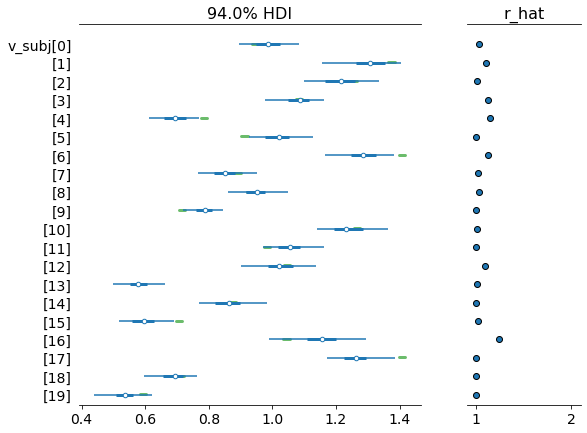

In [214]:
az.plot_forest(az_hddm,
              rope={'v_subj': [{'v_subj_dim_0': i, 'rope': (gt_params['v_subj'][i] - 0.01, gt_params['v_subj'][i] + 0.01)} for i in range(20)]},
              kind = 'forestplot',
              var_names=["v_subj"],
              combined = True,
              figsize = (9, 7),
              r_hat = True
              )

In [215]:
data = az.load_arviz_data('radon')

In [216]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [228]:

pathlib.Path('data/hierarchical/' + \
             'ddm_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6').mkdir(parents = True, 
                                                                                exist_ok = True)